### **Importing Necessary Libraries**

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import glob
import os
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn import metrics
from sklearn.metrics import confusion_matrix

In [ ]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=25

In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Makeup_Detection",  #### load images from a directory.
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),  #### takes parameters such as directory path, seed for shuffling, image size, and batch size.
    batch_size=BATCH_SIZE ###  ### The dataset is stored in the dataset variable.
)

Found 90 files belonging to 2 classes.


In [ ]:
class_names = dataset.class_names
class_names ## the different categories

['MakeUp', 'No Makeup']

### **Display Sample Images**

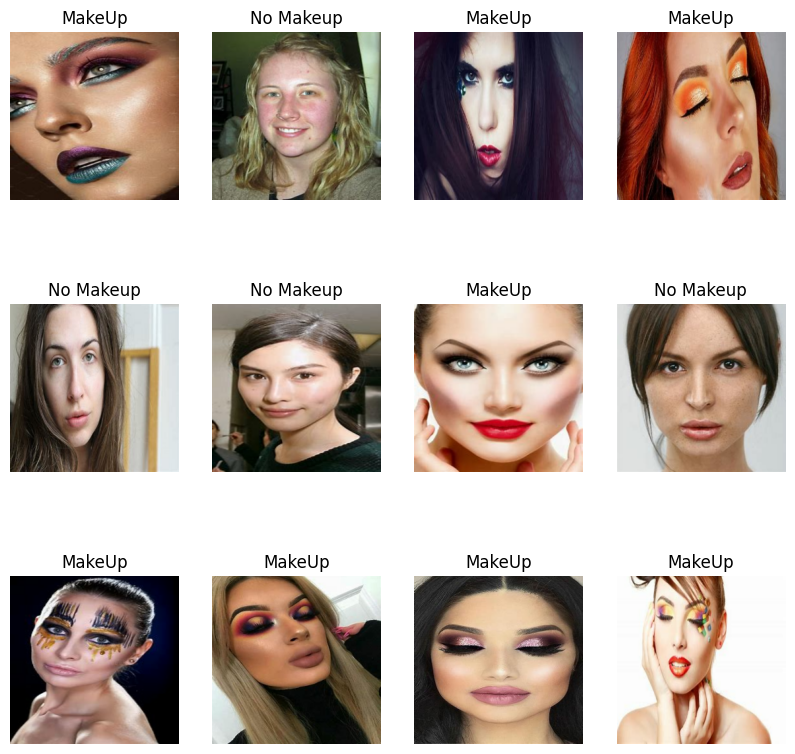

In [ ]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [ ]:
import os
from PIL import Image

PATH = "/content/drive/MyDrive/Makeup_Detection"
image_paths = []
response_list = []

for class_folder in os.listdir(PATH):
    class_path = os.path.join(PATH, class_folder)
    if os.path.isdir(class_path):
        for image_name in os.listdir(class_path):
            image_path = os.path.join(class_path, image_name)
            image_paths.append(image_path)
            response_list.append(class_folder)

print("Total images:", len(image_paths))
print("Total responses:", len(response_list))


Total images: 90
Total responses: 90


### **Split the dataset into train and test dataset**

In [ ]:
train_size = int(0.9*(len(image_paths)))
print(train_size)
test_size = int(0.1*(len(image_paths)))

train_set = tf.data.Dataset.from_tensor_slices((image_paths[:train_size], response_list[:train_size]))
test_set = tf.data.Dataset.from_tensor_slices((image_paths[test_size:], response_list[test_size:]))

81


In [ ]:
def readImage(path,ch = 3, resize=(150,150)):
	di = tf.io.read_file(path)
	di = tf.image.decode_jpeg(di, channels=ch)
	di = tf.image.convert_image_dtype(di, dtype=tf.float32)
	di = tf.image.resize(di, resize)
	return di

### **Function to load the data that includes images and respective labels**

In [1]:
def load_data(image_path, label):
    img = readImage(image_path, 3, (150,150))
    return (img, label)


In [ ]:
train_set = (train_set
    .map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(64)
    .prefetch(tf.data.AUTOTUNE)
)

In [ ]:
test_set = (test_set
    .map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(64)
    .prefetch(tf.data.AUTOTUNE)
)

### **Build the layers of CNN model**

In [ ]:
from tensorflow.keras import layers,models

cnn_model = models.Sequential([
    layers.Conv2D(filters=30, kernel_size=(3, 3), activation='relu', input_shape=(150, 150, 3), padding = 'same'),
    layers.MaxPooling2D((2, 2)),

    # layers.BatchNormalization(),

    layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding = 'same'),
    layers.MaxPooling2D((2, 2)),

    # layers.BatchNormalization(),

    # layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding = 'same'),
    # layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    # layers.Dropout(0.25),
    layers.Dense(3, activation='softmax')
])


In [ ]:
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 30)      840       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 30)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        17344     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 37, 37, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 87616)             0         
                                                                 
 dense (Dense)               (None, 64)                5

### **Compile the Model**

In [ ]:
cnn_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(response_list)

### **Convert numerical labels to one-hot encoded vectors**

In [ ]:
from keras.utils import to_categorical
one_hot_labels = to_categorical(encoded_labels)

In [ ]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    ### training, testing and validation dataset
    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [ ]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

### **Data Augmentation**

In [ ]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [ ]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)


In [ ]:
import tensorflow as tf

IMAGE_SIZE = (150, 150)

# Resize and rescale the input images
resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Resizing(*IMAGE_SIZE),
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
])

# Apply resizing and rescaling to the dataset
train_ds_resized = train_ds.map(lambda x, y: (resize_and_rescale(x), y))
val_ds_resized = val_ds.map(lambda x, y: (resize_and_rescale(x), y))
test_ds_resized = test_ds.map(lambda x, y: (resize_and_rescale(x), y))

# ... define and compile your model ...

# Train the model
history = cnn_model.fit(
    train_ds_resized,
    batch_size=BATCH_SIZE,
    validation_data=val_ds_resized,
    epochs=20,
    verbose=1
)


Epoch 1/20
2/2 [==============================] - 4s 1s/step - loss: 0.4822 - accuracy: 0.7812
Epoch 2/20
2/2 [==============================] - 4s 2s/step - loss: 0.7928 - accuracy: 0.7188
Epoch 3/20
2/2 [==============================] - 4s 2s/step - loss: 0.9933 - accuracy: 0.5312
Epoch 4/20
2/2 [==============================] - 4s 1s/step - loss: 0.5020 - accuracy: 0.7656
Epoch 5/20
2/2 [==============================] - 3s 1s/step - loss: 0.7142 - accuracy: 0.6562
Epoch 6/20
2/2 [==============================] - 4s 2s/step - loss: 0.6040 - accuracy: 0.6719
Epoch 7/20
2/2 [==============================] - 3s 1s/step - loss: 0.4858 - accuracy: 0.8125
Epoch 8/20
2/2 [==============================] - 3s 1s/step - loss: 0.5339 - accuracy: 0.7500
Epoch 9/20
2/2 [==============================] - 5s 2s/step - loss: 0.5385 - accuracy: 0.7031
Epoch 10/20
2/2 [==============================] - 3s 1s/step - loss: 0.4750 - accuracy: 0.7812
Epoch 11/20
2/2 [==============================] 

In [ ]:
import tensorflow as tf

# Resize the input images
resized_test_ds = test_ds.map(lambda x, y: (tf.image.resize(x, (150, 150)), y))

# Evaluate the model on the resized test dataset
scores = cnn_model.evaluate(resized_test_ds)


1/1 [==============================] - 1s 651ms/step - loss: 69.7408 - accuracy: 0.8846


In [ ]:
test_pred = cnn_model.predict(test_set)

2/2 [==============================] - 2s 286ms/step


### **Confusion Matrix**

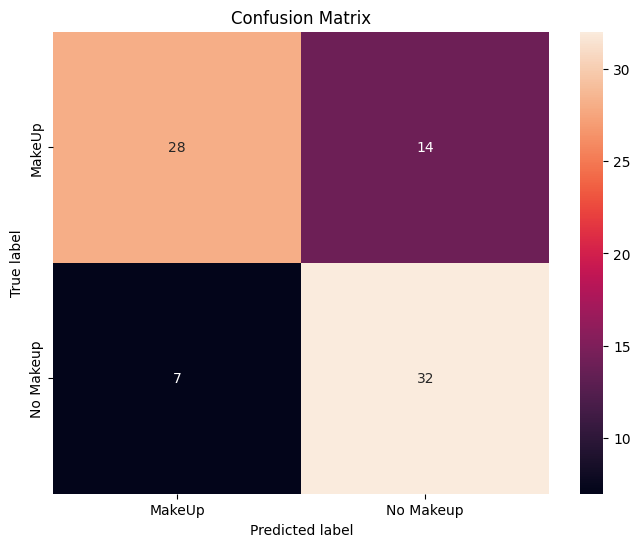

In [ ]:
# Convert predicted labels from one-hot encoded vectors to numerical labels
y_pred = np.argmax(test_pred, axis=1)

# Convert true labels to numerical labels
label_encoder = LabelEncoder()
y_true = label_encoder.fit_transform(test_response)

# Compute the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred)

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mtx, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix")
plt.show()


### **Prediction**

1/1 [==============================] - 0s 162ms/step


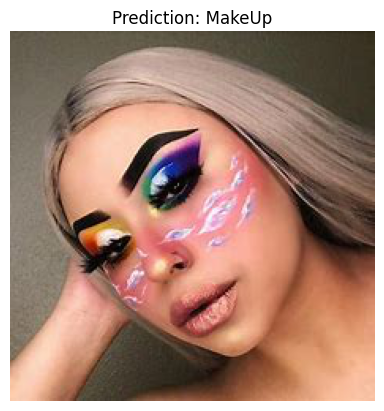

In [ ]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Function to preprocess the input image
def preprocess_image(image_path):
    image = Image.open(image_path)
    image = image.resize(IMAGE_SIZE)
    image = np.array(image) / 255.0
    return image

# Function to make a prediction on the input image
def make_prediction(image_path):
    image = preprocess_image(image_path)
    image = np.expand_dims(image, axis=0)
    prediction = cnn_model.predict(image)
    class_index = np.argmax(prediction[0])
    class_label = class_names[class_index]
    return class_label

# Function to display the input image and prediction result
def display_prediction(image_path, prediction):
    image = Image.open(image_path)
    plt.imshow(image)
    plt.axis('off')
    plt.title('Prediction: ' + prediction)
    plt.show()

# Provide the path to the input image
input_image_path = '/content/m7.jpg'

# Make prediction
prediction = make_prediction(input_image_path)

# Display prediction result
display_prediction(input_image_path, prediction)


1/1 [==============================] - 0s 34ms/step


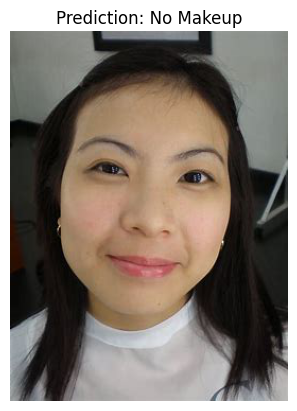

In [ ]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Function to preprocess the input image
def preprocess_image(image_path):
    image = Image.open(image_path)
    image = image.resize(IMAGE_SIZE)
    image = np.array(image) / 255.0
    return image

# Function to make a prediction on the input image
def make_prediction(image_path):
    image = preprocess_image(image_path)
    image = np.expand_dims(image, axis=0)
    prediction = cnn_model.predict(image)
    class_index = np.argmax(prediction[0])
    class_label = class_names[class_index]
    return class_label

# Function to display the input image and prediction result
def display_prediction(image_path, prediction):
    image = Image.open(image_path)
    plt.imshow(image)
    plt.axis('off')
    plt.title('Prediction: ' + prediction)
    plt.show()

# Provide the path to the input image
input_image_path = '/content/n34.jpg'

# Make prediction
prediction = make_prediction(input_image_path)

# Display prediction result
display_prediction(input_image_path, prediction)
